# **Crescimento do índice do GDP para os anos 2024-2028**

## **Contextualização:**

"Na maioria dos anos desde 1980, o crescimento do PIB global tem sido relativamente consistente, geralmente flutuando entre dois e cinco por cento de crescimento de ano para ano. As exceções mais notáveis ​​​​a isso foram durante a Grande Recessão em 2009 e novamente em 2020 durante o Covid- 19, onde a economia global realmente encolheu em ambos os anos. Enquanto a economia mundial continua a lidar com o impacto econômico da pandemia, bem como as consequências da invasão russa da Ucrânia em 2022, o futuro permanece incerto, porém atual estimativas sugerem que o crescimento anual retornará a valores estáveis ​​de cerca de 3% em 2028."

Aaron O'Neill, 10 de maio de 2023

## **Desafio :**
O desafio visa avaliar o desenvolvimento de um EDA (análise exploratória de dados) e os conhecimentos/insights relacionados a um tipo clássico de problema de ciência de dados: séries temporais. Para isso, gostaria de ver o crescimento do índice do PIB de cada país nos anos 2024-2028, comparando-os posteriormente com o previsto pelo Statistica. Além disso, é necessário substituir os campos "no data" por valores numéricos, utilizando as inferências de sua preferência.

## **Objetivo :**

Prever o crescimento do índice do PIB de cada país nos anos 2024-2028.

## **Fluxo de Análise:**

  1. **Importe as bibliotecas necessárias**
  2. **Leia e entenda os dados**
  3. **Análise Exploratória de Dados**
  4. **Preparação de Dados**
  5. **Decomposição da série temporal**
  6. **Criando e avaliando a previsão de séries temporais**

## **Vamos começar...**

#**1. Importando bibliotecas**

In [165]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import Image
from scipy.stats import variation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima import auto_arima



In [166]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

#**2. Lendo e entendendo os dados**

In [167]:
data = pd.read_excel('imf-dm-export-20230513.xlsx')  # Lê o arquivo Excel e armazena os dados em um DataFrame chamado 'data'
data.head()  # Exibe as primeiras linhas do DataFrame 'data'

,Real GDP growth (Annual percent change),1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,3.9,-2.4,no data,no data,no data,no data,no data,no data,no data,no data
2,Albania,2.7,5.7,2.9,1.1,2,-1.5,5.6,-0.8,-1.4,...,2.1,-3.5,8.5,3.7,2.2,3.3,3.4,3.4,3.4,3.4
3,Algeria,-5.4,3,6.4,5.4,5.6,5.6,-0.2,-0.7,-1.9,...,1,-5.1,3.4,2.9,2.6,2.6,2.2,2.1,1.7,1.8
4,Andorra,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,2,-11.2,8.9,8.7,1.3,1.5,1.5,1.5,1.5,1.5


In [168]:
data_copy= data.copy() # Criando uma cópia do conjunto de dados
data_pivoted = pd.melt(data_copy, id_vars=['Real GDP growth (Annual percent change)'], var_name='Year', value_name='GDP') # Pivotando o conjunto de dados
data_pivoted.rename(columns={'Real GDP growth (Annual percent change)': 'Country'}, inplace=True) # Renomeando a coluna 'Real GDP growth (Annual percent change)' para 'Country'
data_pivoted.head() # Exibindo o novo conjunto de dados pivotado

,Country,Year,GDP
0,NaN,1980,NaN
1,Afghanistan,1980,no data
2,Albania,1980,2.7
3,Algeria,1980,-5.4
4,Andorra,1980,no data


In [169]:
data_pivoted.shape # Obter a forma (número de linhas e colunas) do DataFrame

(11319, 3)

In [170]:
data_pivoted.info() # Exibir informações sobre o DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11319 entries, 0 to 11318
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  11221 non-null  object
 1   Year     11319 non-null  object
 2   GDP      11172 non-null  object
dtypes: object(3)
memory usage: 265.4+ KB


In [171]:
data_pivoted.describe() # Exibir estatísticas descritivas do DataFrame

,Country,Year,GDP
count,11221,11319,11172
unique,229,49,447
top,Afghanistan,1980,no data
freq,49,231,881


**Inferência: Ao analisar o dataframe percebemos que existem valores inconsistentes fazendo com que as análises de estatística descritiva não estejam na forma esperada, para a resolução desse problema precisamos tratar os dados.**

#**3. Análise exploratória dos dados**

##**3.1 Valores ausentes**

In [172]:
data_eda = data_pivoted.copy()
data_eda # Exibir DataFrame

,Country,Year,GDP
0,NaN,1980,NaN
1,Afghanistan,1980,no data
2,Albania,1980,2.7
3,Algeria,1980,-5.4
4,Andorra,1980,no data
...,...,...,...
11314,Other advanced economies,2028,2.3
11315,Sub-Saharan Africa,2028,4.4
11316,World,2028,3
11317,NaN,2028,NaN


**Inferência:**

1.   **Várias células contêm "NaN" (Not a Number), que indica valores ausentes. Isso pode ser devido à falta de dados para aquele país e ano específico.**
2.   **Algumas células contêm "no data", que também indica falta de dados para o crescimento do GDP real.**


In [173]:
data_eda.isnull().sum()

Country     98
Year         0
GDP        147
dtype: int64

**Inferência: Há valores ausentes nos dados.**

###**3.1.1Para continuar a análise exploratória dos dados é necessário substituir os valores 'no data' not a number(NaN)**

In [174]:
def replace_no_data_with_nan(dataframe):
    dataframe['GDP'] = dataframe['GDP'].replace('no data', np.nan)

replace_no_data_with_nan(data_eda)

In [175]:
data_eda

,Country,Year,GDP
0,NaN,1980,NaN
1,Afghanistan,1980,NaN
2,Albania,1980,2.7
3,Algeria,1980,-5.4
4,Andorra,1980,NaN
...,...,...,...
11314,Other advanced economies,2028,2.3
11315,Sub-Saharan Africa,2028,4.4
11316,World,2028,3.0
11317,NaN,2028,NaN


##**3.2 Outliers**

In [176]:
data_eda.describe()

,GDP
count,10291.000000
mean,3.345428
std,5.704939
min,-54.200000
25%,1.500000
50%,3.400000
75%,5.500000
max,148.000000


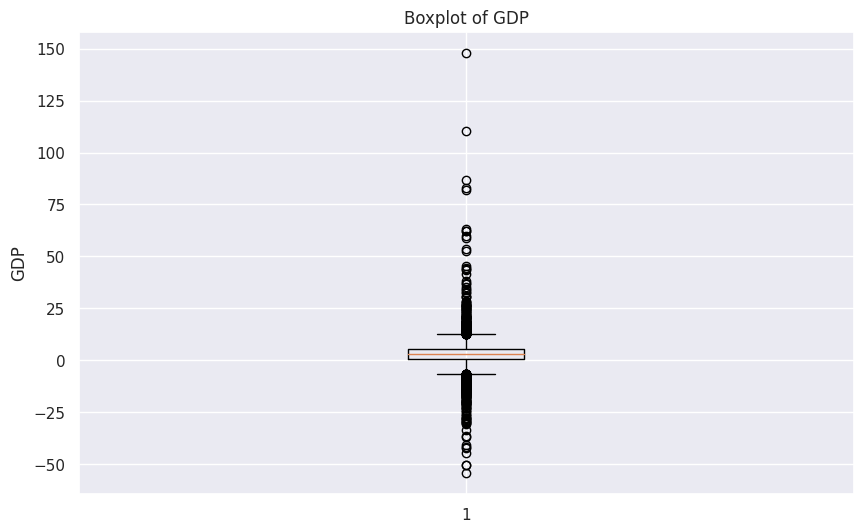

In [177]:
data_eda_bx = data_eda.copy()
data_eda_bx['GDP'] = data_eda_bx['GDP'].fillna(0)
# Criar um boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_eda_bx['GDP'])
plt.title('Boxplot of GDP')
plt.ylabel('GDP')
plt.show()

**Inferência: podemos ver claramente que há outliers nos dados.**

**Por existir outliers nos dados, precisamos investigar mais afundo quais os paises que estão com valores muito acima e abaixo dos demais.**

In [178]:
data_eda_bx[data_eda_bx['GDP'] >= 50].sort_values('GDP', ascending=False)

,Country,Year,GDP
3981,Equatorial Guinea,1997,148.0
4674,Equatorial Guinea,2000,110.5
7492,Libya,2012,86.8
2865,Kuwait,1992,82.8
5394,Iraq,2003,81.8
6590,Nauru,2008,63.3
9774,Guyana,2022,62.3
3719,Bosnia and Herzegovina,1996,62.2
4905,Equatorial Guinea,2001,60.0
10036,Macao SAR,2023,58.9


In [179]:
data_eda_bx[data_eda_bx['GDP'] <= -40 ].sort_values('GDP', ascending=True)

,Country,Year,GDP
9343,Macao SAR,2020,-54.2
7261,Libya,2011,-50.3
7554,"South Sudan, Republic of",2012,-50.3
2836,Georgia,1992,-44.9
2176,Lebanon,1989,-42.2
3379,Rwanda,1994,-41.9
2634,Kuwait,1991,-41.0


##**3.3 Análise Bivariada**

In [180]:
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11319 entries, 0 to 11318
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  11221 non-null  object 
 1   Year     11319 non-null  object 
 2   GDP      10291 non-null  float64
dtypes: float64(1), object(2)
memory usage: 265.4+ KB


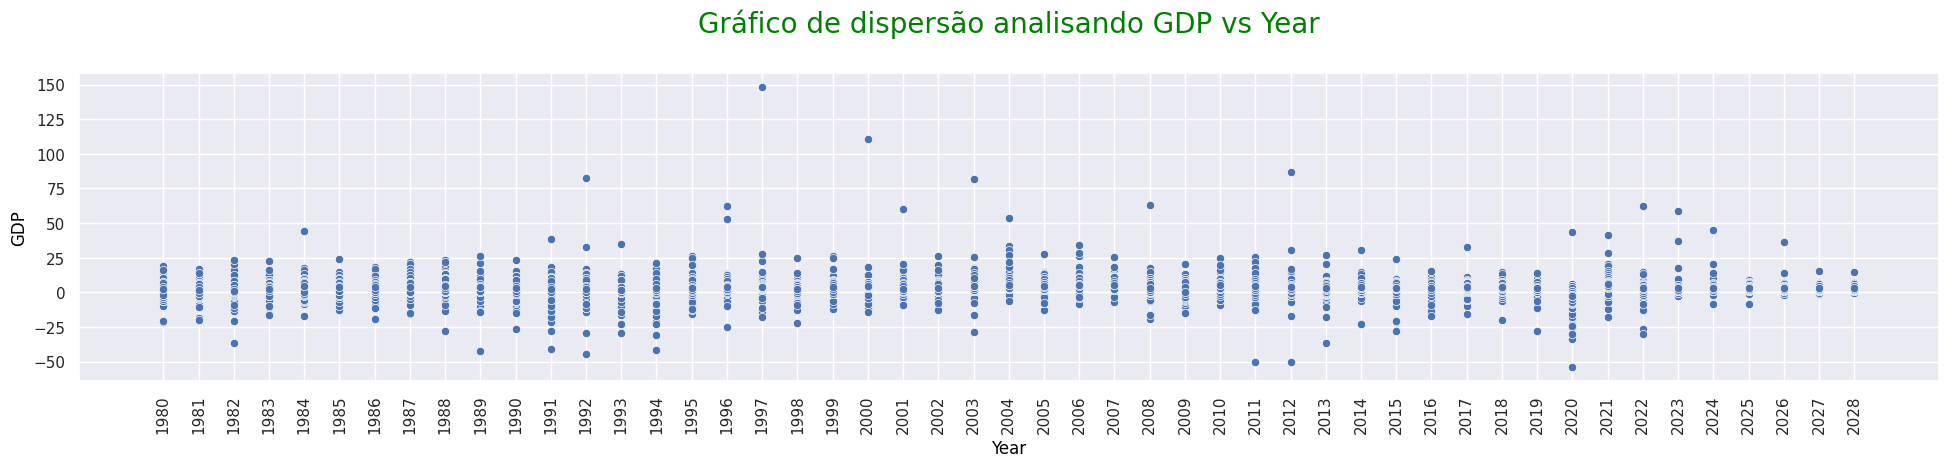

In [181]:
# Configuração do tamanho da figura do gráfico
plt.figure(figsize=[24, 4])

# Criação do gráfico de dispersão
sns.scatterplot(data=data_eda, x='Year', y='GDP')

# Título do gráfico
plt.title("Gráfico de dispersão analisando GDP vs Year\n", fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})

# Rótulos dos eixos x e y
plt.xlabel("Year", fontdict={'fontsize': 12, 'fontweight': 5, 'color': 'Black'})
plt.ylabel("GDP", fontdict={'fontsize': 12, 'fontweight': 5, 'color': 'Black'})

# Escolha entre 1, 5 e 10 anos de intervalo nos rótulos do eixo x
interval = 1  # Alterne entre 1, 5 e 10 para o intervalo desejado
plt.xticks(range(min(data_eda['Year']), max(data_eda['Year']) + 1, interval))
plt.xticks(rotation=90)

# Exibe o gráfico
plt.show()

**Este código gera um gráfico de dispersão que ilustra a relação entre o Produto Interno Bruto (GDP) e o ano (Year).
Cada ponto no gráfico representa um valor de GDP associado a um determinado ano, possibilitando a visualização das mudanças no GDP ao longo dos anos.
Isso facilita a identificação de tendências ou padrões temporais relacionados à evolução econômica.**


#**4. Preparação de Dados**

##**4.1 Tratando linhas nulas**

In [182]:
def remove_rows_with_nan_or_no_data(data_pivoted):
    # Criar uma cópia do DataFrame
    data_cleaned = data_pivoted.copy()

    # Encontrar índices das linhas com valores NaN ou 'no data' na coluna 'Country'
    rows_to_remove = data_cleaned[data_cleaned['Country'].isin([np.nan, 'no data'])].index

    # Remover as linhas correspondentes
    data_cleaned.drop(rows_to_remove, inplace=True)

    return data_cleaned

# Chamar a função para remover linhas com valores NaN ou 'no data' na coluna 'Country'
data_cleaned = remove_rows_with_nan_or_no_data(data_pivoted)
data_cleaned

,Country,Year,GDP
1,Afghanistan,1980,no data
2,Albania,1980,2.7
3,Algeria,1980,-5.4
4,Andorra,1980,no data
5,Angola,1980,2.4
...,...,...,...
11313,Middle East and Central Asia,2028,3.7
11314,Other advanced economies,2028,2.3
11315,Sub-Saharan Africa,2028,4.4
11316,World,2028,3


**Esta função percorre todo o dataframe e a linha que tiver valores NaN são excluídas.**

##**4.2 Criando novas features**

In [183]:
def remove_comma(country_name):
    if isinstance(country_name, str):
        return country_name.replace(',', '')
    return country_name

# Aplicar a função à coluna 'Country'
data_cleaned['Country'] = data_cleaned['Country'].apply(remove_comma)

In [184]:
# Carregar o arquivo CSV que contém países e continentes
df_continents = pd.read_csv("Continentes.csv", header=None, encoding="ISO-8859-1")
continent_dict = dict(zip(df_continents[0], df_continents[1]))

# Carregar o seu DataFrame original
df_original = data_cleaned.copy()

# Criar uma função para atribuir continentes
def assign_continent(country):
    return continent_dict.get(country, "Others")

# Adicionar a nova coluna "Continent" ao DataFrame original
df_original["Continent"] = df_original["Country"].apply(assign_continent)

# Reorganizar as colunas para que "Continent" fique antes de "Country"
df_original = df_original[["Continent", "Country", "Year", "GDP"]]

# Remover as linhas com 'Others' no continente
df_filtered = df_original[df_original['Continent'] != 'Others']

def replace_no_data_with_nan(dataframe):
    dataframe['GDP'] = dataframe['GDP'].replace('no data', np.nan)

replace_no_data_with_nan(df_filtered)
data_pd = df_filtered.copy()

##**4.3 Imputação de dados ausentes**

###**4.3.1 Calculando a mediana com outliers**

In [185]:
data_pd.describe()

,GDP
count,8781.000000
mean,3.347534
std,6.064496
min,-54.200000
25%,1.400000
50%,3.400000
75%,5.700000
max,148.000000


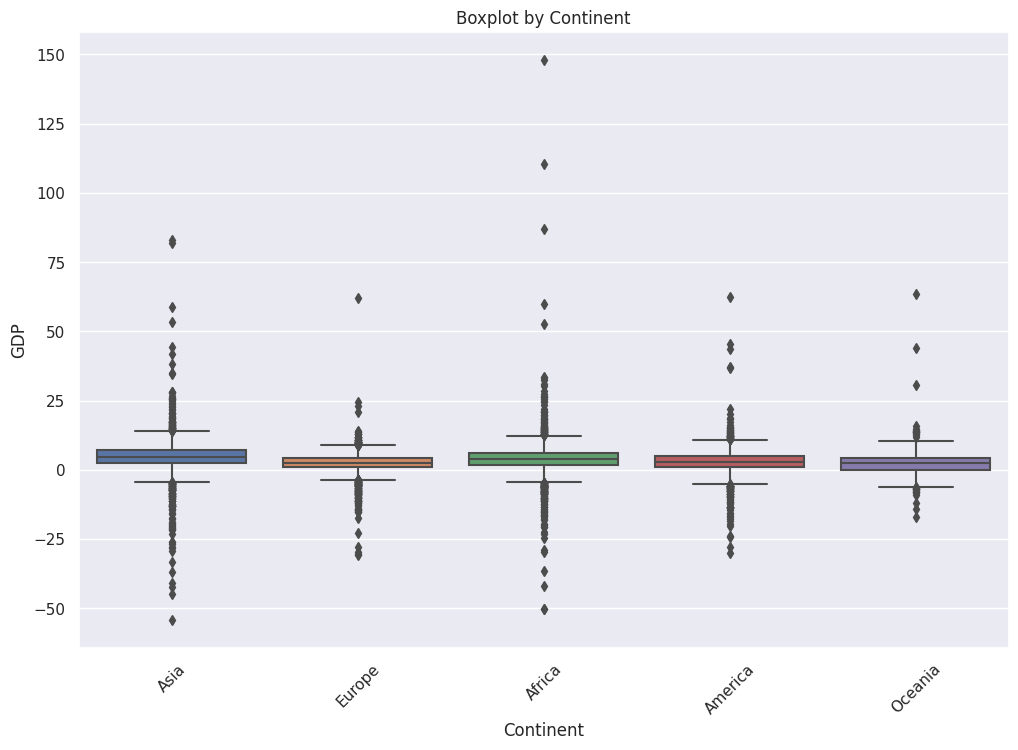

In [186]:
# Configure the graphics style
sns.set(style="darkgrid")

# Create boxplots separated by continent
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_pd, x='Continent', y='GDP')
plt.title('Boxplot by Continent')
plt.xlabel('Continent')
plt.ylabel('GDP')
plt.xticks(rotation=45)
plt.show()

In [187]:
data_y_out = data_pd.copy()

# Agrupar os países por continente e calcular a média e mediana do GDP para cada continente
data_out = data_y_out.groupby('Continent')['GDP'].agg(['mean', 'median']).reset_index()

# Renomear as colunas para ficarem mais claras
data_out.rename(columns={'mean': 'Média_out', 'median': 'Mediana_out'}, inplace=True)

# Exibir o dataframe resultante
data_out

,Continent,Média_out,Mediana_out
0,Africa,3.697746,3.9
1,America,2.745833,3.0
2,Asia,4.571099,4.8
3,Europe,2.341816,2.6
4,Oceania,2.387863,2.4


###**4.3.2 Calculando a mediana ápos retirar outliers**

In [188]:
# Carregar os dados
data = data_pd.copy()
data = data.fillna(0)

# Filtrar outliers de GDP
filtered_data = data[(data['GDP'] >= -40) & (data['GDP'] <= 50)]

# Exibir o novo dataframe sem os outliers
filtered_data


,Continent,Country,Year,GDP
1,Asia,Afghanistan,1980,0.0
2,Europe,Albania,1980,2.7
3,Africa,Algeria,1980,-5.4
4,Europe,Andorra,1980,0.0
5,Africa,Angola,1980,2.4
...,...,...,...,...
11280,Asia,Vietnam,2028,6.7
11281,Asia,West Bank and Gaza,2028,2.0
11282,Asia,Yemen,2028,5.5
11283,Africa,Zambia,2028,5.1


In [189]:
filtered_data_desc = filtered_data.copy()
filtered_data_desc= filtered_data_desc.drop(columns=['Year'])
filtered_data_desc.describe()

,GDP
count,9585.000000
mean,3.004361
std,5.003272
min,-36.800000
25%,0.500000
50%,3.100000
75%,5.400000
max,45.300000


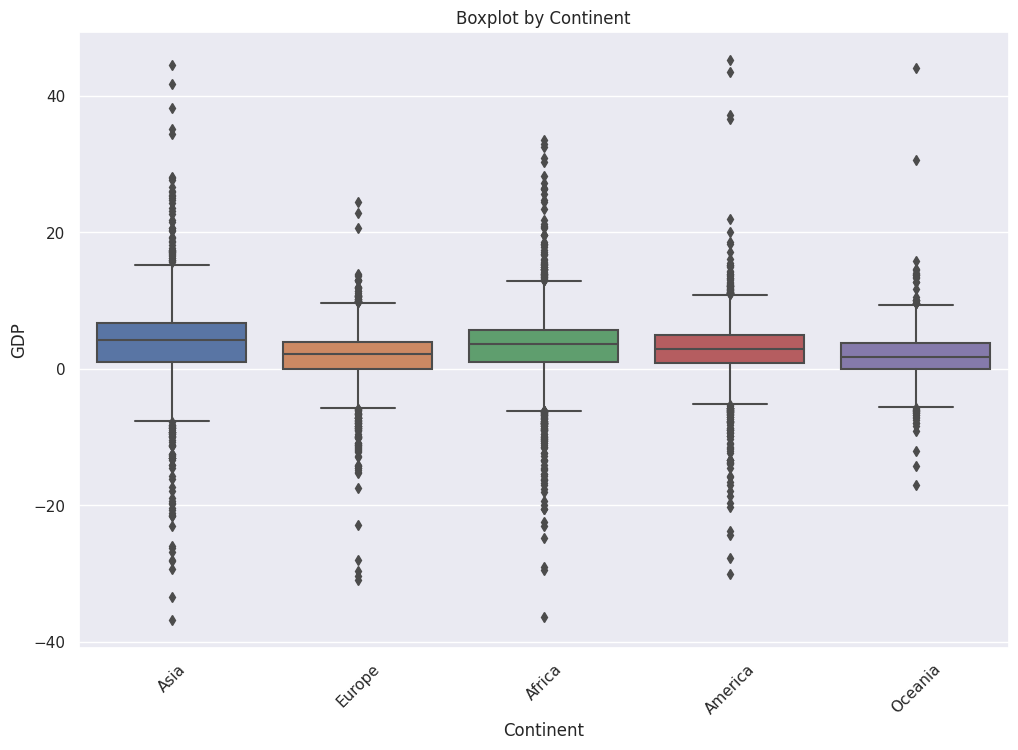

In [190]:
# Configure the graphics style
sns.set(style="darkgrid")

# Create boxplots separated by continent
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_data, x='Continent', y='GDP')
plt.title('Boxplot by Continent')
plt.xlabel('Continent')
plt.ylabel('GDP')
plt.xticks(rotation=45)
plt.show()

In [191]:
data_no_out = filtered_data.copy()

# Agrupar os países por continente e calcular a média e mediana do GDP para cada continente
data_n_out = data_no_out.groupby('Continent')['GDP'].agg(['mean', 'median']).reset_index()

# Renomear as colunas para ficarem mais claras
data_n_out.rename(columns={'mean': 'Média_no_out', 'median': 'Mediana_no_out'}, inplace=True)

# Exibir o dataframe resultante
data_n_out

,Continent,Média_no_out,Mediana_no_out
0,Africa,3.362282,3.7
1,America,2.693364,2.9
2,Asia,4.011993,4.2
3,Europe,2.015385,2.2
4,Oceania,1.946861,1.8


###**4.3.3 Comparando resultados**

In [192]:
# Supondo que você tenha os dataframes merged_data com as colunas reorganizadas
merged_data = data_out.merge(data_n_out, on='Continent', suffixes=('_out', '_n_out'))

# Selecionar as colunas desejadas para média e mediana
media_columns = ['Média_out', 'Média_no_out']
mediana_columns = ['Mediana_out', 'Mediana_no_out']

# Criar um novo dataframe com as colunas reorganizadas
reorganized_data = pd.concat([merged_data[['Continent'] + media_columns], merged_data[mediana_columns]], axis=1)

# Calcular as diferenças e criar as colunas "out_diff" e "no_out_diff"
reorganized_data['out_diff'] = reorganized_data['Mediana_out'] - reorganized_data['Média_out']
reorganized_data['no_out_diff'] = reorganized_data['Mediana_no_out'] - reorganized_data['Média_no_out']

# Exibir o dataframe resultante
reorganized_data

,Continent,Média_out,Média_no_out,Mediana_out,Mediana_no_out,out_diff,no_out_diff
0,Africa,3.697746,3.362282,3.9,3.7,0.202254,0.337718
1,America,2.745833,2.693364,3.0,2.9,0.254167,0.206636
2,Asia,4.571099,4.011993,4.8,4.2,0.228901,0.188007
3,Europe,2.341816,2.015385,2.6,2.2,0.258184,0.184615
4,Oceania,2.387863,1.946861,2.4,1.8,0.012137,-0.146861


**Inferência: A coluna "no_out_diff" indica que a remoção dos outliers tende a diminuir a mediana, sugerindo que esses outliers têm valores relativamente altos que estão elevando a mediana.**

###**4.3.4 Imputando dados.**

**Percebemos que a presença de outliers impactam na média e mediana mesmo que essa diferença seja pequena em alguns continentes podem ser significativas, então nesse caso  usar a mediana para preenchimento de valores ausentes pode ser mais apropriado, além disso vimos que o melhor método para a imputação de dados é retirando os outliers antes de aplicar a mediana.**

In [193]:
data_median = filtered_data.copy()

# Agrupar por continente e ano e calcular a mediana
grouped = data_median.groupby(['Continent', 'Year'])['GDP'].median().reset_index()

grouped

,Continent,Year,GDP
0,Africa,1980,0.55
1,Africa,1981,0.75
2,Africa,1982,1.40
3,Africa,1983,0.00
4,Africa,1984,2.10
...,...,...,...
240,Oceania,2024,2.80
241,Oceania,2025,2.60
242,Oceania,2026,2.40
243,Oceania,2027,2.40


In [194]:
# Combinar os DataFrames usando o método merge
merged_data = pd.merge(data_pd, grouped, on=['Continent', 'Year'], suffixes=('', '_median'))

# Preencher os valores NaN em GDP com os valores da coluna GDP_median
merged_data['GDP'] = merged_data['GDP'].fillna(merged_data['GDP_median'])

# Remover a coluna GDP_median, se necessário
merged_data = merged_data.drop(columns=['GDP_median'])

merged_data

,Continent,Country,Year,GDP
0,Asia,Afghanistan,1980,0.0
1,Asia,Armenia,1980,0.0
2,Asia,Azerbaijan,1980,0.0
3,Asia,Bahrain,1980,7.5
4,Asia,Bangladesh,1980,0.0
...,...,...,...,...
9599,Oceania,Samoa,2028,2.3
9600,Oceania,Solomon Islands,2028,3.0
9601,Oceania,Tonga,2028,1.8
9602,Oceania,Tuvalu,2028,2.2


##**4.4 Divisão do dataframe em train e teste**


In [195]:
data_train_test = merged_data.copy()
# Dividir os dados em conjunto de treino e teste
train_data = data_train_test[data_train_test['Year'] < 2024]
test_data = data_train_test[data_train_test['Year'] >= 2024]

# Separar features (variáveis independentes) e target (GDP)
X_train = train_data[['Continent', 'Country', 'Year']]
y_train = train_data['GDP']
X_test = test_data[['Continent', 'Country', 'Year']]
y_test = test_data['GDP']


#**5. Decomposição da série temporal**

**A escolha desse processo tem como intenção entender os diferentes componentes que compõem nossa série temporal, como tendência, sazonalidade e componente residual (ou aleatório). Isso é útil para compreender os padrões subjacentes nos dados e pode ajudar na previsão e análise.**

In [196]:
data_det = merged_data.copy()
data_det.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9604 entries, 0 to 9603
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Continent  9604 non-null   object 
 1   Country    9604 non-null   object 
 2   Year       9604 non-null   object 
 3   GDP        9604 non-null   float64
dtypes: float64(1), object(3)
memory usage: 375.2+ KB


**Convertendo a coluna 'Year' para formato de datetime**

In [197]:
data_det['Year'].head()

0    1980
1    1980
2    1980
3    1980
4    1980
Name: Year, dtype: object

In [198]:
data_det['Year'] = pd.to_datetime(data_det['Year'], format='%Y').dt.to_period('Y') # Convertendo a coluna 'Year' para o formato de datetime


In [199]:
data_det

,Continent,Country,Year,GDP
0,Asia,Afghanistan,1980,0.0
1,Asia,Armenia,1980,0.0
2,Asia,Azerbaijan,1980,0.0
3,Asia,Bahrain,1980,7.5
4,Asia,Bangladesh,1980,0.0
...,...,...,...,...
9599,Oceania,Samoa,2028,2.3
9600,Oceania,Solomon Islands,2028,3.0
9601,Oceania,Tonga,2028,1.8
9602,Oceania,Tuvalu,2028,2.2


In [200]:
data_det_dec = data_det.copy()
# Group the data by Order Date for sum of Sales
data1 = data_det_dec.groupby(['Year'])['GDP'].sum()
data1

Year
1980     432.90
1981     442.15
1982     246.35
1983     325.50
1984     742.80
1985     523.00
1986     647.75
1987     626.15
1988     693.05
1989     583.90
1990     489.35
1991     358.55
1992     525.10
1993     329.25
1994     449.40
1995     719.80
1996     831.20
1997     932.70
1998     650.45
1999     646.80
2000     869.80
2001     710.70
2002     669.65
2003     935.20
2004    1134.55
2005     993.50
2006    1102.80
2007    1120.50
2008     820.50
2009       7.00
2010     867.70
2011     779.70
2012     692.90
2013     634.40
2014     665.00
2015     504.80
2016     548.70
2017     615.40
2018     628.80
2019     510.90
2020    -967.65
2021    1051.80
2022     770.70
2023     680.05
2024     732.60
2025     678.85
2026     688.25
2027     655.35
2028     652.20
Freq: A-DEC, Name: GDP, dtype: float64

In [201]:
data1 = pd.DataFrame(data1) # Convert to data frame

In [202]:
data1.index = data1.index.to_timestamp() # Converting the index to timestamp

In [203]:
data1.index.dtype

dtype('<M8[ns]')

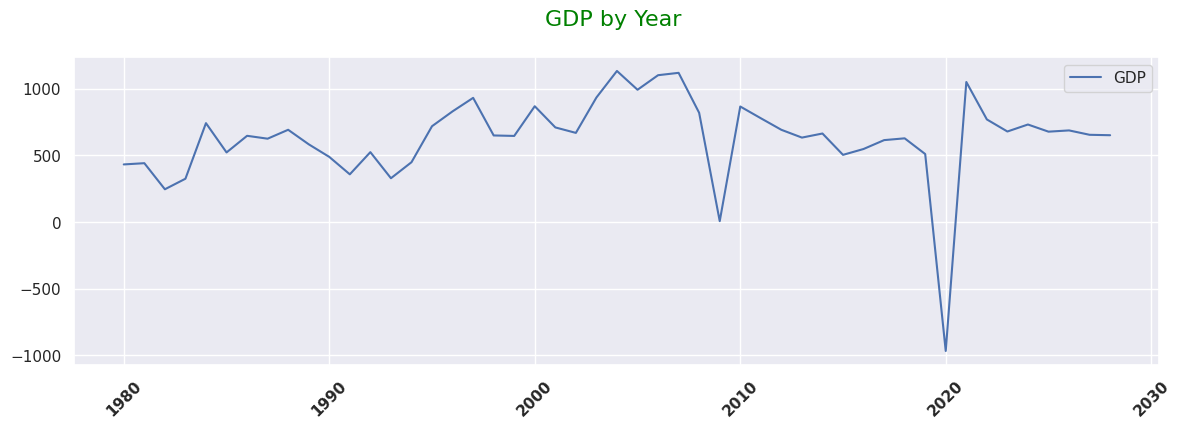

In [204]:
plt.figure(figsize=(14,4))
plt.plot(data1, label='GDP')
plt.legend(loc='best')
plt.title('GDP by Year \n', fontdict={'fontsize': 16, 'fontweight' : 5, 'color' : 'Green'})
plt.xticks(rotation = 45,fontweight="bold")
plt.show()

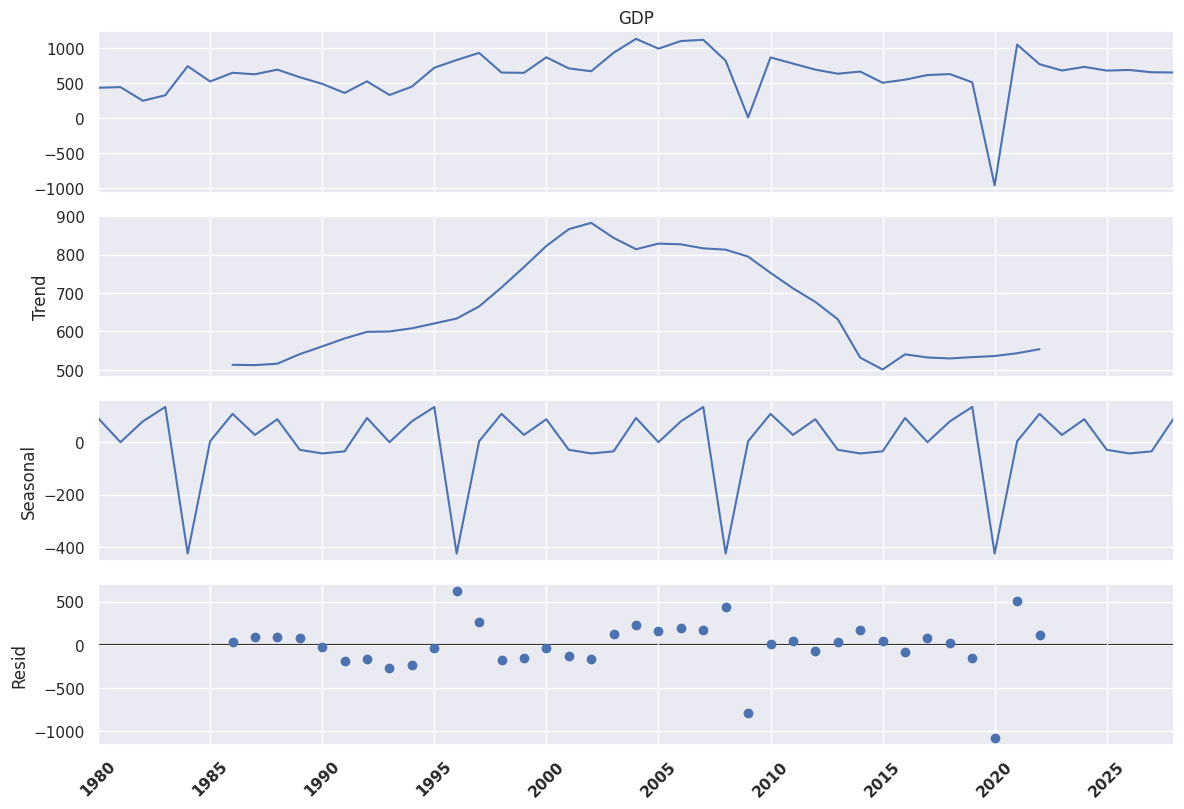

In [205]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
period = 12
decomposition = sm.tsa.seasonal_decompose(data1.GDP, model='additive', period=period) # additive seasonal index
fig = decomposition.plot()
plt.xticks(rotation = 45,fontweight="bold")
plt.show()

#**6. Criando e avaliando a previsão de séries temporais**

##**6.1 Verifique se a série temporal é estacionária**

In [206]:
data_outliers = merged_data.copy()
data_no_outliers = data_outliers[(data_outliers['GDP'] >= -40) & (data_outliers['GDP'] <= 50)]
data_no_outliers = data_no_outliers.drop('Continent', axis=1)
data_no_outliers

,Country,Year,GDP
0,Afghanistan,1980,0.0
1,Armenia,1980,0.0
2,Azerbaijan,1980,0.0
3,Bahrain,1980,7.5
4,Bangladesh,1980,0.0
...,...,...,...
9599,Samoa,2028,2.3
9600,Solomon Islands,2028,3.0
9601,Tonga,2028,1.8
9602,Tuvalu,2028,2.2


###**Augmented Dickey-Fuller (ADF) e KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test**

In [207]:
# Função para realizar o teste ADF e imprimir os resultados
def perform_adf_test(data_series):
    data_no_outliers = adfuller(data_series)
    adf_statistic = data_no_outliers[0]
    p_valor = data_no_outliers[1]
    valores_críticos = data_no_outliers[4]

    print(f'Estatística ADF: {adf_statistic}')
    print(f'P-valor: {p_valor}')
    print('Valores Críticos:')
    for chave, valor in valores_críticos.items():
        print(f'   {chave}: {valor}')

    if p_valor < 0.05:
        print("A série é estacionária")
    else:
        print("A série não é estacionária")

# Função para realizar o teste KPSS e imprimir os resultados
def perform_kpss_test(data_series):
    resultado_kpss = kpss(data_series, regression='c')
    kpss_statistic = resultado_kpss[0]
    p_valor = resultado_kpss[1]
    valores_críticos = resultado_kpss[3]

    print(f'Estatística KPSS: {kpss_statistic}')
    print(f'P-valor: {p_valor}')
    print('Valores Críticos:')
    for chave, valor in valores_críticos.items():
        print(f'   {chave}: {valor}')

    if p_valor < 0.05:
        print("A série não é estacionária")
    else:
        print("A série é estacionária")


# Extrair a coluna com os valores da série temporal (GDP)
dados = data_no_outliers['GDP']

# Realizar o teste ADF
print("Teste ADF:")
perform_adf_test(dados)

# Realizar o teste KPSS
print("\nTeste KPSS:")
perform_kpss_test(dados)


Teste ADF:
Estatística ADF: -10.190469197111579
P-valor: 6.34197360893877e-18
Valores Críticos:
   1%: -3.431035214676779
   5%: -2.8618428225409547
   10%: -2.566931187330754
A série é estacionária

Teste KPSS:
Estatística KPSS: 0.6174600580387298
P-valor: 0.02104908563284274
Valores Críticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
A série não é estacionária


##**6.2 Construindo modelo Auto regressivo para previsão do GDP**

In [208]:
# Certifique-se de que o DataFrame tenha as colunas 'Country', 'Year' e 'Transformed_GDP'
df = data_no_outliers.copy()
# Define os anos para os quais você deseja fazer previsões
anos_previsao = [2024, 2025, 2026, 2027, 2028]

# Inicializa uma lista para armazenar os resultados
resultados = []

# Inicializa listas para armazenar os resultados de MAPE e RMSE
mape_scores = []
rmse_scores = []

# Iterar através dos países únicos
unique_countries = df['Country'].unique()
for country in unique_countries:
    country_df = df[df['Country'] == country]

    # Extrai os valores históricos de GDP
    valores_historicos = country_df['GDP'].values

    # Encontre automaticamente os melhores parâmetros ARIMA usando auto_arima
    modelo_arima = auto_arima(valores_historicos, seasonal=True, stepwise=True, trace=False, suppress_warnings=True, error_action="ignore")

    # Faça previsões para os anos de 2024 a 2028
    previsoes = modelo_arima.predict(n_periods=len(anos_previsao))

    # Obtenha os valores reais apenas para os anos em que temos dados
    valores_reais = country_df[country_df['Year'].isin(anos_previsao)]['GDP'].values

    # Calcule o MAPE e o RMSE apenas para esses anos
    mape = np.nan if (valores_reais == 0).any() else np.mean(np.abs((valores_reais - previsoes[:len(valores_reais)]) / valores_reais)) * 100
    rmse = np.sqrt(mean_squared_error(valores_reais, previsoes[:len(valores_reais)]))

    # Crie um DataFrame com as previsões
    previsoes_df = pd.DataFrame({'Country': [country] * len(valores_reais), 'Year': anos_previsao[:len(valores_reais)], 'GDP_Predicted': previsoes[:len(valores_reais)], 'MAPE': [mape] * len(valores_reais), 'RMSE': [rmse] * len(valores_reais)})

    # Armazene os resultados
    resultados.append(previsoes_df)
    mape_scores.append(mape)
    rmse_scores.append(rmse)

# Combine os resultados em um único DataFrame
predicted = pd.concat(resultados, ignore_index=True)

# Calcule a média dos MAPE e RMSE para todos os países, excluindo os 'nan'
mape_scores = [score for score in mape_scores if not np.isnan(score)]
media_mape = np.mean(mape_scores)
media_rmse = np.mean(rmse_scores)
print(f'Média do MAPE para todos os países: {media_mape}')
print(f'Média do RMSE para todos os países: {media_rmse}')

# Exiba o resultado final (DataFrame) com MAPE e RMSE
predicted.to_csv('predicted.csv', index= False)
predicted


Média do MAPE para todos os países: 30.615152839661548
Média do RMSE para todos os países: 1.082991185090117


,Country,Year,GDP_Predicted,MAPE,RMSE
0,Afghanistan,2024,2.510704,12.57682,0.511507
1,Afghanistan,2025,3.144711,12.57682,0.511507
2,Afghanistan,2026,3.361647,12.57682,0.511507
3,Afghanistan,2027,3.528862,12.57682,0.511507
4,Afghanistan,2028,3.657751,12.57682,0.511507
...,...,...,...,...,...
975,Vanuatu,2024,4.353061,8.97012,0.380635
976,Vanuatu,2025,3.884649,8.97012,0.380635
977,Vanuatu,2026,3.278325,8.97012,0.380635
978,Vanuatu,2027,2.710107,8.97012,0.380635


###**6.3 Retirando os anos de 2009 e 2020 ( Recessão e Pandemia) e observando os resultados**

In [209]:
data_no_09_20 = data_no_outliers.copy()

# Remove as linhas com os anos de 2009 e 2020
data_no_09_20  = data_no_09_20 [~data_no_09_20 ['Year'].isin([2009, 2020])]

# Exibe o DataFrame resultante
data_no_09_20


,Country,Year,GDP
0,Afghanistan,1980,0.0
1,Armenia,1980,0.0
2,Azerbaijan,1980,0.0
3,Bahrain,1980,7.5
4,Bangladesh,1980,0.0
...,...,...,...
9599,Samoa,2028,2.3
9600,Solomon Islands,2028,3.0
9601,Tonga,2028,1.8
9602,Tuvalu,2028,2.2


In [210]:
# Certifique-se de que o DataFrame tenha as colunas 'Country', 'Year' e 'Transformed_GDP'
df = data_no_09_20.copy()
# Define os anos para os quais você deseja fazer previsões
anos_previsao = [2024, 2025, 2026, 2027, 2028]

# Inicializa uma lista para armazenar os resultados
resultados = []

# Inicializa listas para armazenar os resultados de MAPE e RMSE
mape_scores = []
rmse_scores = []

# Iterar através dos países únicos
unique_countries = df['Country'].unique()
for country in unique_countries:
    country_df = df[df['Country'] == country]

    # Extrai os valores históricos de GDP
    valores_historicos = country_df['GDP'].values

    # Encontre automaticamente os melhores parâmetros ARIMA usando auto_arima
    modelo_arima = auto_arima(valores_historicos, seasonal=True, stepwise=True, trace=False, suppress_warnings=True, error_action="ignore")

    # Faça previsões para os anos de 2024 a 2028
    previsoes = modelo_arima.predict(n_periods=len(anos_previsao))

    # Obtenha os valores reais apenas para os anos em que temos dados
    valores_reais = country_df[country_df['Year'].isin(anos_previsao)]['GDP'].values

    # Calcule o MAPE e o RMSE apenas para esses anos
    mape = np.nan if (valores_reais == 0).any() else np.mean(np.abs((valores_reais - previsoes[:len(valores_reais)]) / valores_reais)) * 100
    rmse = np.sqrt(mean_squared_error(valores_reais, previsoes[:len(valores_reais)]))

    # Crie um DataFrame com as previsões
    previsoes_df = pd.DataFrame({'Country': [country] * len(valores_reais), 'Year': anos_previsao[:len(valores_reais)], 'GDP_Predicted': previsoes[:len(valores_reais)], 'MAPE': [mape] * len(valores_reais), 'RMSE': [rmse] * len(valores_reais)})

    # Armazene os resultados
    resultados.append(previsoes_df)
    mape_scores.append(mape)
    rmse_scores.append(rmse)

# Combine os resultados em um único DataFrame
predicted_no_09_20 = pd.concat(resultados, ignore_index=True)

# Calcule a média dos MAPE e RMSE para todos os países, excluindo os 'nan'
mape_scores = [score for score in mape_scores if not np.isnan(score)]
media_mape = np.mean(mape_scores)
media_rmse = np.mean(rmse_scores)
print(f'Média do MAPE para todos os países: {media_mape}')
print(f'Média do RMSE para todos os países: {media_rmse}')

# Exiba o resultado final (DataFrame) com MAPE e RMSE
predicted_no_09_20.to_excel('predicted_no_09_20.xlsx', index= False)
predicted_no_09_20


Média do MAPE para todos os países: 33.41857602835251
Média do RMSE para todos os países: 1.1686407370339378


,Country,Year,GDP_Predicted,MAPE,RMSE
0,Afghanistan,2024,3.533447,13.562767,0.493362
1,Afghanistan,2025,3.650331,13.562767,0.493362
2,Afghanistan,2026,3.730697,13.562767,0.493362
3,Afghanistan,2027,3.799209,13.562767,0.493362
4,Afghanistan,2028,3.847448,13.562767,0.493362
...,...,...,...,...,...
975,Vanuatu,2024,2.887234,14.375811,0.590198
976,Vanuatu,2025,2.887234,14.375811,0.590198
977,Vanuatu,2026,2.887234,14.375811,0.590198
978,Vanuatu,2027,2.887234,14.375811,0.590198


**Desempenho do Modelo ARIMA**

Foi realizado um estudo de previsão de séries temporais utilizando o modelo ARIMA (AutoRegressive Integrated Moving Average) com otimização automática de parâmetros usando a função auto_arima.

**Configuração do Modelo:**

Modelo: **ARIMA**

Método de Otimização de Parâmetros: **auto_arima**

Métrica de Avaliação: **MAPE (Mean Absolute Percentage Error)**

**Resultado:**

A média de MAPE obtida para as previsões utilizando o modelo ARIMA foi de 31%.

**Observações:**



*   O modelo ARIMA foi escolhido devido à sua capacidade de lidar com séries temporais univariadas e à otimização automática de parâmetros.
*   O MAPE é uma métrica comumente usada para avaliar o desempenho de modelos de previsão, representando a porcentagem média de erro absoluto em relação aos valores reais.
*   O valor de MAPE de 31% indica que, em média, as previsões do modelo ARIMA têm um erro absoluto médio de 31% em relação aos valores reais.  

Este resultado fornece uma avaliação do desempenho do modelo ARIMA em suas previsões e pode ser usado para tomar decisões informadas sobre sua utilidade em cenários específicos.

#**Links:**


*   https://analisemacro.com.br/data-science/python/estacionariedade_series_temporais/#:~:text=Caso%203%3A%20KPSS%20indica%20estacionariedade,a%20nova%20s%C3%A9rie%20%C3%A9%20estacion%C3%A1ria.
*   http://leg.ufpr.br/~lucambio/STemporais/STemporaisIII.html
*   https://medium.com/analytics-vidhya/time-series-forecasting-a-complete-guide-d963142da33f



